In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import regex as re
import datetime as dt
import statistics as stats
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import random as pyr
import pingouin as pg

#### <b> Random Number Generation - II</b>
The distributions involved in the case include those from <b>logistic family, loglogistic family, lognormal family, and normal family</b>. As the distributions are valued on either the real line or a subset of the real line, truncation has to be performed.

The following snippets will evaluate the truncated distributions to see if there are any abnormalities.

- To find solutions for truncation, the source file of RANLIB was viewed but the algorithm does not support truncation for most of the continuous distributions except exponential. And in exponential it is the max() truncation being used.

In certain cases, the min-max truncation can lead the sample data to have abnormal high frequency at the maximum and minimum edges.

There are some alternatives, apart from the previous one discussed in price analysis, another one is as follows:

- Truncation with Uniform:
> let val be a sample point drawn from the distribution, let a be the min value and b the max value for truncation.

> if $ val < a$ or $val > b$:
> > let val be a sample point drawn from $U[a, b]$

> return val

The resultant distribution will definitely have different statistic properties yet can be similar enough as an approximation of the original distribution.

In [76]:
# declare parameters

n_mu = 21528.2
n_sigma = 3702.3 ** 0.5

loglogit_gamma = -7252.4
loglogit_beta = 33859
loglogit_alpha = 11.756

logit_mu = 23273.1
logit_var = 1791.8

a1 = 19.084 + 6.7773
b1= 44.194

a2 = 18.293 + 7.6351
b2 = 13.114

In [77]:
def uniform_based_truncate(rng, lo, hi):
    val = rng()
    if lo > val or hi < val:
        val = np.random.uniform(lo,hi)
    return val


def uniform_based_truncate_arr(vec, lo, hi):
    return [np.random.uniform(lo, hi) if lo > v or hi < v else v  for v in vec]


def simple_truncate(rng, lo, hi):
    val = rng()
    val = max(lo, val)
    val = min(hi, val)
    return val


def simple_truncate_arr(vec, lo, hi):
    vec = np.fmax(vec, lo)
    vec = np.fmin(vec, hi)
    return vec


def self_based_truncate(rng, lo, hi):
    val = rng()
    while lo > val or hi < val:
        val = rng()
    return val


def self_based_truncate_arr(vec, rng, lo, hi):
    res = []
    for i in range(len(vec)):
        val = vec[i]
        while lo > val or hi < val:
            val = rng()
        res.append(val)
    return res

##### Evaluation of lognormal distribution sampling

(0.0, 100.0)

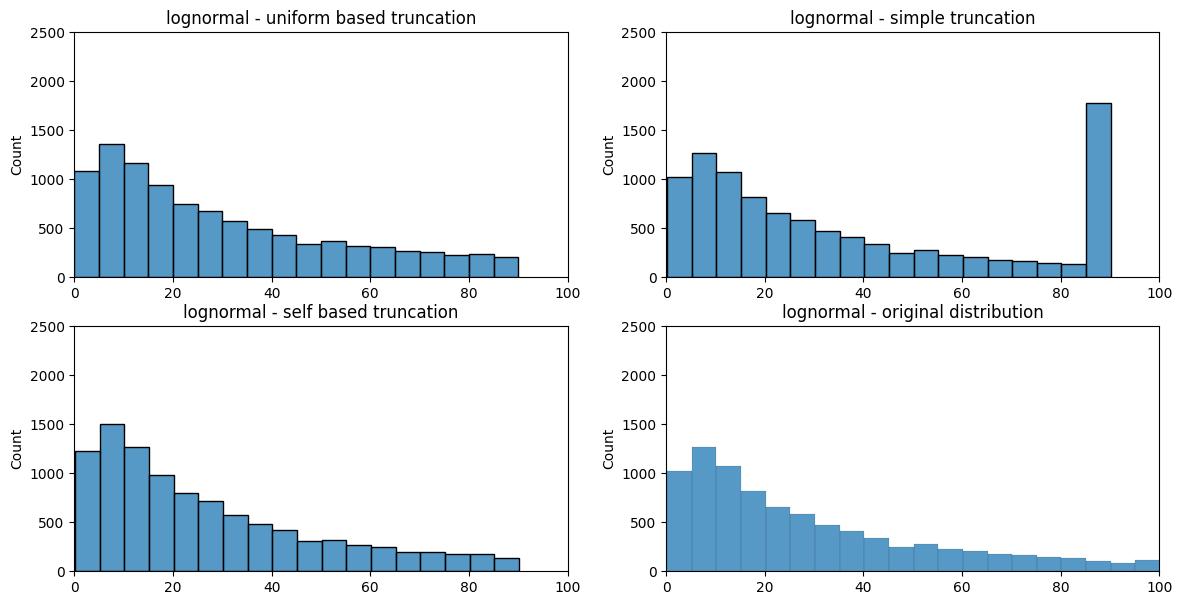

In [78]:
rng = lambda: pyr.lognormvariate(np.log(a2), np.log(b2 ** 0.5))


fig, ax =plt.subplots(2,2)
fig.set_figwidth(14)
fig.set_figheight(7)
sample_size = 10000
y_lim = (0,sample_size / 4)
x_lim = (0, 100)


arr_samples = [rng() for i in range(sample_size)]


plt.subplot(2,2,1)
arr_temp = uniform_based_truncate_arr(arr_samples, 0, 90)
sns.histplot(x = arr_temp, binwidth = 5,).set_title('lognormal - uniform based truncation')
plt.ylim(y_lim)
plt.xlim(x_lim)


plt.subplot(2,2,2)
arr_temp = simple_truncate_arr(arr_samples, 0, 90)
sns.histplot(x = arr_temp, binwidth = 5).set_title('lognormal - simple truncation')
plt.ylim(y_lim)
plt.xlim(x_lim)


plt.subplot(2,2,3)
arr_temp = self_based_truncate_arr(arr_samples, rng, 0, 90)
sns.histplot(x = arr_temp, binwidth = 5).set_title('lognormal - self based truncation')
plt.ylim(y_lim)
plt.xlim(x_lim)


plt.subplot(2,2,4)
sns.histplot(x = arr_samples, binwidth = 5).set_title('lognormal - original distribution')
plt.ylim(y_lim)
plt.xlim(x_lim)

Based on the graphs, <b>min-max truncation may not be a good choice for truncating the lognormal distribution.</b>

From the perspective of efficiency, simple truncation is the most efficient yet it leads to abnormally high observations of boundary value.

Uniform-based truncation is as efficient as simple truncation and is better than simple truncation in maintaining the original shape of the unbounded distribution. 

However, owing to its uniform nature, the variance of the truncated distribution is slightly lower than that of the original one. It reduces the observations from high density intervals and increases the observations from low density intervals.

Self-based truncation is the best in maintaining the original shape of the distribution. However, it is the most inefficient one as it relies on resampling from the original distribution. That means the number of trials needed to get the truncated value is indefinite and actually unbounded (valued on the set of natural numbers). 

The uniform-based truncation may be a good compromise between RNG quality and efficiency.
<br></br>
##### Evaluation of the logistic distribution sampling.
- As shown below, the simple truncation could be used for logistic distributions.

(22800.0, 23800.0)

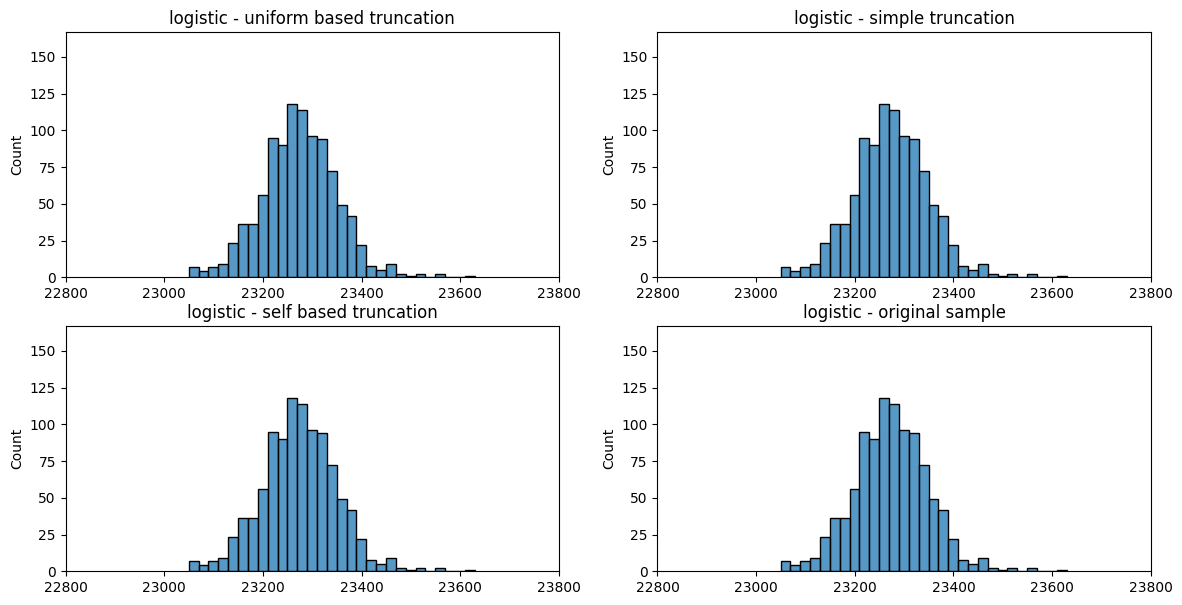

In [79]:
fig, ax =plt.subplots(2,2)
fig.set_figwidth(14)
fig.set_figheight(7)
sample_size = 1000
y_lim = (0,sample_size / 6)
x_lim = (22800, 23800)
bin_width = 20

arr_samples = scipy.stats.logistic.rvs(size = sample_size, loc = logit_mu, scale = logit_var ** 0.5)


plt.subplot(2,2,1)
arr_temp = uniform_based_truncate_arr(arr_samples, 0, 30000)
sns.histplot(x = arr_temp, binwidth = bin_width,).set_title('logistic - uniform based truncation')
plt.ylim(y_lim)
plt.xlim(x_lim)


plt.subplot(2,2,2)
arr_temp = simple_truncate_arr(arr_samples, 0, 30000)
sns.histplot(x = arr_temp, binwidth = bin_width).set_title('logistic - simple truncation')
plt.ylim(y_lim)
plt.xlim(x_lim)


plt.subplot(2,2,3)
arr_temp = self_based_truncate_arr(arr_samples, lambda: scipy.stats.logistic.rvs(size = 1, loc = logit_mu, scale = logit_var ** 0.5)[0],  0, 30000)
sns.histplot(x = arr_temp, binwidth = bin_width).set_title('logistic - self based truncation')
plt.ylim(y_lim)
plt.xlim(x_lim)


plt.subplot(2,2,4)
sns.histplot(x = arr_samples, binwidth = bin_width).set_title('logistic - original sample')
plt.ylim(y_lim)
plt.xlim(x_lim)

In  the case of logistic family, the simple truncation suffices to generate the data.

##### Evaluation of the loglogistic family

Text(0.5, 1.0, 'loglogistic - original sample')

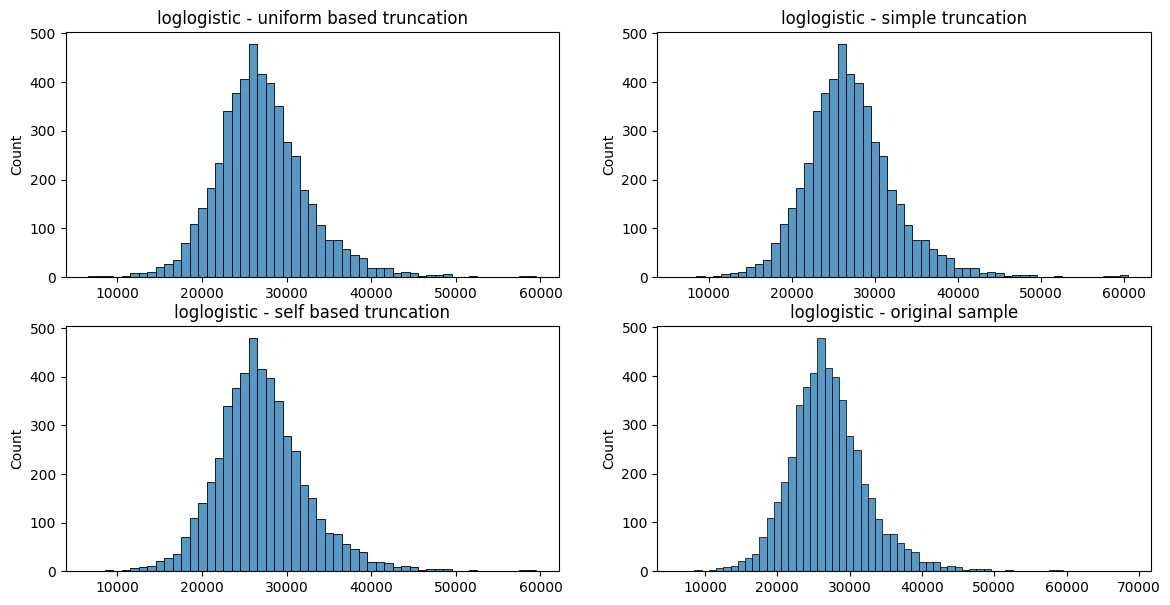

In [80]:
fig, ax =plt.subplots(2,2)
fig.set_figwidth(14)
fig.set_figheight(7)
sample_size = 5000
y_lim = (0,sample_size / 6)
x_lim = (22800, 23800)
bin_width = 1000

arr_samples = scipy.stats.fisk.rvs(size = sample_size, loc = loglogit_gamma , scale = loglogit_beta, c = loglogit_alpha)


plt.subplot(2,2,1)
arr_temp = uniform_based_truncate_arr(arr_samples, 0, 60000)
sns.histplot(x = arr_temp, binwidth = bin_width,).set_title('loglogistic - uniform based truncation')
# plt.ylim(y_lim)
# plt.xlim(x_lim)


plt.subplot(2,2,2)
arr_temp = simple_truncate_arr(arr_samples, 0, 60000)
sns.histplot(x = arr_temp, binwidth = bin_width).set_title('loglogistic - simple truncation')
# plt.ylim(y_lim)
# plt.xlim(x_lim)


plt.subplot(2,2,3)
arr_temp = self_based_truncate_arr(arr_samples, lambda: scipy.stats.fisk.rvs(size = 1, loc = loglogit_gamma , scale = loglogit_beta, c = loglogit_alpha)[0],  0, 60000)
sns.histplot(x = arr_temp, binwidth = bin_width).set_title('loglogistic - self based truncation')
# plt.ylim(y_lim)
# plt.xlim(x_lim)


plt.subplot(2,2,4)
sns.histplot(x = arr_samples, binwidth = bin_width).set_title('loglogistic - original sample')
# plt.ylim(y_lim)
# plt.xlim(x_lim)

##### Evaluation of the normal family

Text(0.5, 1.0, 'normal - original sample')

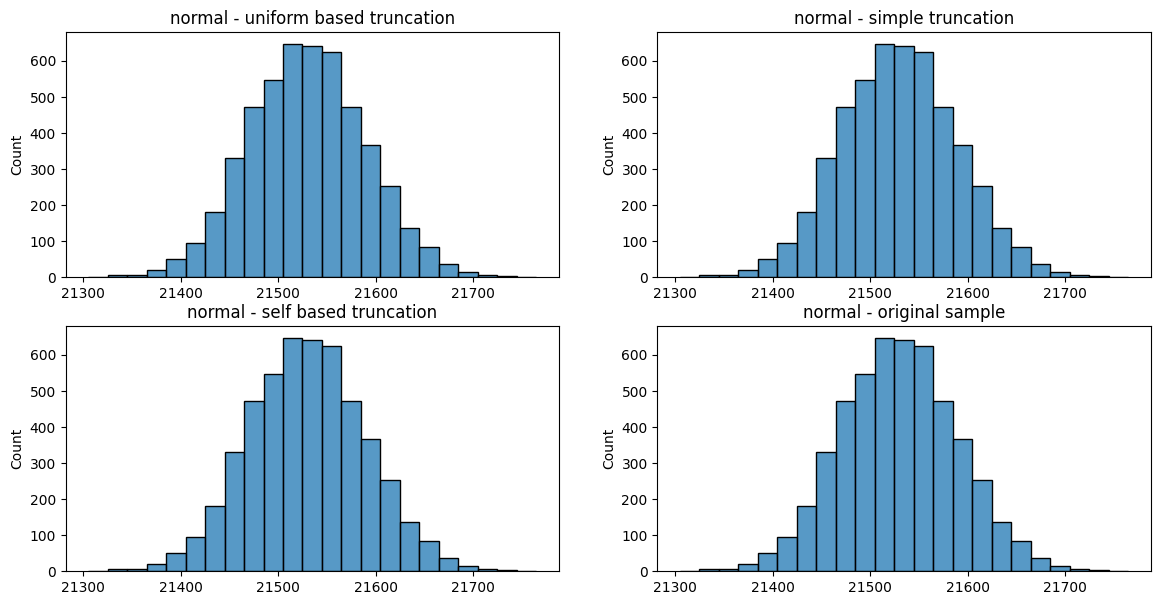

In [81]:
fig, ax =plt.subplots(2,2)
fig.set_figwidth(14)
fig.set_figheight(7)
sample_size = 5000
y_lim = (0,sample_size)
x_lim = (22800, 23800)
bin_width = 20

arr_samples = scipy.stats.norm.rvs(size = sample_size, loc = n_mu , scale = n_sigma)


plt.subplot(2,2,1)
arr_temp = uniform_based_truncate_arr(arr_samples, 0, 60000)
sns.histplot(x = arr_temp, binwidth = bin_width,).set_title('normal - uniform based truncation')
# plt.ylim(y_lim)
# plt.xlim(x_lim)


plt.subplot(2,2,2)
arr_temp = simple_truncate_arr(arr_samples, 0, 60000)
sns.histplot(x = arr_temp, binwidth = bin_width).set_title('normal - simple truncation')
# plt.ylim(y_lim)
# plt.xlim(x_lim)


plt.subplot(2,2,3)
arr_temp = self_based_truncate_arr(arr_samples, lambda: scipy.stats.norm.rvs(size = sample_size, loc = n_mu , scale = n_sigma)[0],  0, 60000)
sns.histplot(x = arr_temp, binwidth = bin_width).set_title('normal - self based truncation')
# plt.ylim(y_lim)
# plt.xlim(x_lim)


plt.subplot(2,2,4)
sns.histplot(x = arr_samples, binwidth = bin_width).set_title('normal - original sample')
# plt.ylim(y_lim)
# plt.xlim(x_lim)

#### <b>Summary of RNG Analysis</b>

As for all the involved distributions, simple truncation can be applied to all of them except for lognormal distribution. This is because the lognormal distribution has thick tail. Truncation of the tail part reallocate the large probability density to the truncated edge, leading to abnormal high observations at the edge. The uniform-based truncation was applied on lognormal distribution.

#### <b>Data transform and efficiency optimization</b>

Currently it takes some 17 seconds for an MC simulation of 100 iterations to be completed. To improve efficiency, it is viable to transform the original demand data so as to reduce the computation cost, thereby recuding the total running time of the algorithm.

The average of weekly demand is currently valued around <b>25,000</b>, which leads to some <b>2,500,000</b> computations under a <b>100-iteration</b> simulation. If factored by 0.1, the weekly demand expectation will be around 2,500  and leads to a significant efficiency improement.

In [82]:
df_foodcenter = pd.read_csv('food_center_pred/train.csv')
print(df_foodcenter.shape)
# df_foodcenter.head()

df_foodcenter_meal = pd.read_csv('food_center_pred/meal_info.csv')
print(df_foodcenter_meal.cuisine.value_counts())
#df_foodcenter_meal.head()

df_foodcenter = pd.merge(
    left=df_foodcenter[df_foodcenter.week <= 140], right=df_foodcenter_meal, how='left', on='meal_id')
print(df_foodcenter.shape)
#df_foodcenter.head()


order_by_center = df_foodcenter.groupby('center_id').agg(
    num_orders=pd.NamedAgg(column='num_orders', aggfunc='sum')
)['num_orders'].sort_values(ascending=False)


df_foodcenter_popular = df_foodcenter.loc[
    df_foodcenter.index.map(
        lambda i: df_foodcenter.loc[i, 'center_id'] in order_by_center.index[:6])
]

(456548, 9)
Thai           15
Indian         12
Italian        12
Continental    12
Name: cuisine, dtype: int64
(440172, 11)


In [83]:
print(
    df_foodcenter_popular.groupby(['center_id', 'week']).agg(
        weekly_min_demand = pd.NamedAgg(column='num_orders', aggfunc = 'min'),
        weekly_max_demand = pd.NamedAgg(column='num_orders', aggfunc = 'max'),
    ).max()
)

df_foodcenter_popular.groupby(['center_id', 'week']).agg(
    weekly_min_demand = pd.NamedAgg(column='num_orders', aggfunc = 'min'),
    weekly_max_demand = pd.NamedAgg(column='num_orders', aggfunc = 'max'),
).min()

weekly_min_demand       82
weekly_max_demand    24299
dtype: int64


weekly_min_demand     13
weekly_max_demand    663
dtype: int64

In [84]:
df_foodcenter_popular.num_orders = df_foodcenter_popular.num_orders.map(lambda v: 0.1 * float(v))

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_17192\2514128525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foodcenter_popular.num_orders = df_foodcenter_popular.num_orders.map(lambda v: 0.1 * float(v))


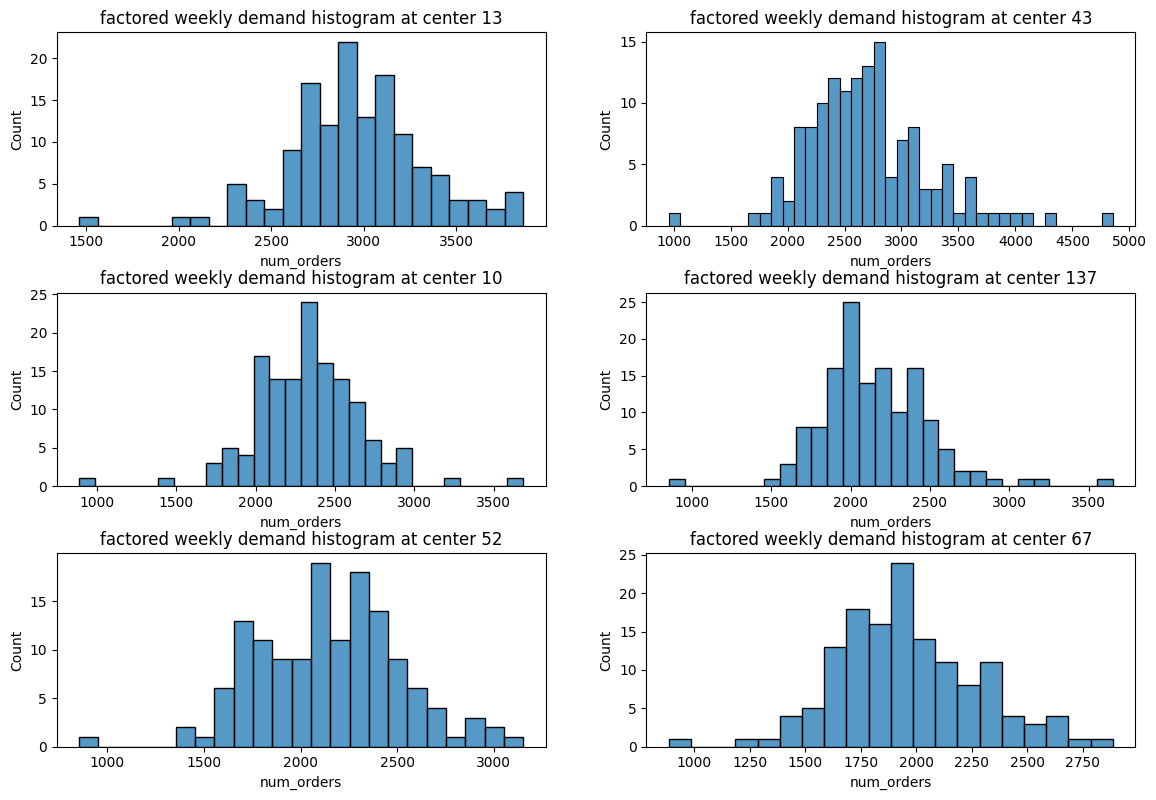

In [85]:
f, a1 = plt.subplots(ncols=2, nrows=3,)
f.tight_layout(pad=0.8)
f.set_figheight(8,)
f.set_figwidth(12,)
output_demand = True
df_demand_matrix = pd.DataFrame()


counter = 1
for c_id in order_by_center.index[:6]:
    plt.subplot(3, 2, counter)
    plt.title("factored weekly demand histogram at center " + str(c_id))
    counter += 1
    df_temp = df_foodcenter_popular[df_foodcenter_popular.center_id == c_id][['week', 'num_orders']]
    df_temp = df_temp.groupby('week').agg(func=lambda col: col.sum())['num_orders'].to_frame()
    
    sns.histplot(data = df_temp, x = 'num_orders',binwidth = 100),

    df_demand_matrix[c_id] = df_temp.num_orders
    if output_demand:
        df_temp.to_csv(f"weekly demand transformed %s.csv" % str(c_id))

    
if output_demand:
    df_foodcenter_popular.groupby('week').agg(func=lambda col: col.sum())['num_orders'].to_frame().to_csv('weekly_aggregated_demand.csv')

In [86]:
df_demand_matrix.shape

(140, 6)

In [87]:
df_demand_matrix.corr()

,13,43,10,137,52,67
13,1.000000,0.777889,0.819696,0.801464,0.814833,0.868785
43,0.777889,1.000000,0.830487,0.833762,0.752583,0.781712
10,0.819696,0.830487,1.000000,0.760201,0.823370,0.796322
137,0.801464,0.833762,0.760201,1.000000,0.737574,0.835977
52,0.814833,0.752583,0.823370,0.737574,1.000000,0.866127
67,0.868785,0.781712,0.796322,0.835977,0.866127,1.000000


<AxesSubplot:>

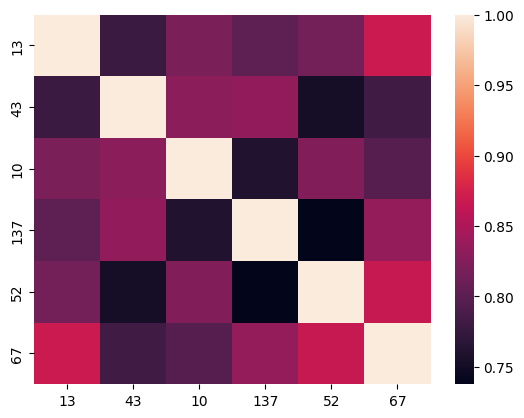

In [88]:
sns.heatmap(data = df_demand_matrix.corr())

In [89]:
counter = 0
for c_id in order_by_center.index[:6]:
    counter += 1
    df_temp = df_foodcenter_popular[df_foodcenter_popular.center_id == c_id]
    df_temp = df_temp.groupby('week').agg(func='sum')['num_orders']
    test_res = scipy.stats.normaltest(df_temp)
    print("center " + str(c_id) + " normality test", end='\t\t')
    print("stat: " + str(round(test_res[0], 4)), end='\t')
    print("p val: " + str(round(test_res[1], 4)), end='\n')


center 13 normality test		stat: 9.1451	p val: 0.0103
center 43 normality test		stat: 16.8223	p val: 0.0002
center 10 normality test		stat: 14.3812	p val: 0.0008
center 137 normality test		stat: 20.7838	p val: 0.0
center 52 normality test		stat: 1.3137	p val: 0.5185
center 67 normality test		stat: 2.5159	p val: 0.2842


#### <b>Modifications for education purpose</b>

This section discusses modification that could be applied to enhance the educational effect.

The case itself is similar to portfolio investment where investors have to consider the correlation among the assets. The assets here are the distribution centers to be invested.

From both the perspectives of economics and common sense, there could be situations where the demand at one location is correlated to the demand at another location. 
- For instance, if two distribution centers are too close, orders may be dispatched randomly to either and the two centers actually share the same customer group, which can be described by $D_{total} - D_{1} = D_{2}$, thereby causing negative correlation. Correlation can be used to represent such geographical factors.

Negative correlation could be built in this case by the following steps:
- define a demand set $ \boldsymbol{S} = \{D_{1}, D_{2}, ... , D_{n}\}$ where negative correlation will be established among each $D_{i}$.
- Fit the distribution of all $D_{i}$ except $D_{n}$.
- Fit the distribution of the sum of all $D_{i}$, denoted as $D_{total}$
- pseudo code for generating negatively correlated demand:
> let total_demand be a sample from $D_{total}$

> let actual_demand be a n-dim vector storing the actual demand at each center, components intialized to zero

> for i = 1, i < n, i++: (the iteration will not access the last element in $\boldsymbol{S}$)

> > let center_demand be a sample from $D_{i}$

> > center_demand = min(center_demand, total_demand)

> > if center_demand == 0:

> > > break the for-loop

> > else:

> > > let actual_demand[i] = center_demand

> > total_demand = total_demand - center_demand

Below is an implement

In [90]:
def sim_neg_cov_rvs(arr_rng, constraint_rng):
    
    total = constraint_rng()
    res = [0 for i in range(len(arr_rng))]

    for i in range(len(arr_rng)):
        rng = arr_rng[i]
        val = rng()
        val = min(val, total)
        if val == 0:
            break
        else:
            res[i] = val
            total -= val
    
    return res

In [91]:
arr_rngs = [
    lambda: pyr.normalvariate(50, 10),
    lambda: pyr.normalvariate(80, 20),
    lambda: pyr.normalvariate(70, 50),
    lambda: pyr.normalvariate(50, 20),
]


cons_rng = lambda : pyr.normalvariate(250, 30)


df_temp = pd.DataFrame(columns=['n1', 'n2', 'n3', 'n4'], dtype=float)

for i in range(100):
    df_temp.loc[i, :] = sim_neg_cov_rvs(arr_rngs, cons_rng)

df_temp.corr()

,n1,n2,n3,n4
n1,1.000000,0.108550,0.028218,-0.188433
n2,0.108550,1.000000,-0.053810,-0.023705
n3,0.028218,-0.053810,1.000000,-0.511207
n4,-0.188433,-0.023705,-0.511207,1.000000


In [92]:
df_temp = df_foodcenter_popular.groupby(['center_id', 'week']).agg(
    weekly_num_orders = pd.NamedAgg(column = 'num_orders', aggfunc = 'sum')
).reset_index()


mat_demand = df_temp.set_index([ 'week', 'center_id'])[['weekly_num_orders']].unstack()
mat_cov = mat_demand.cov()
#mat_cov.column = order_by_center.index[:6]


df_temp = df_temp.groupby('center_id').agg(
    mu = pd.NamedAgg(column = 'weekly_num_orders', aggfunc = 'mean'),
    stddev = pd.NamedAgg(column = 'weekly_num_orders', aggfunc = 'std'),
    var = pd.NamedAgg(column = 'weekly_num_orders', aggfunc = 'var'),
)


arr_mu = df_temp['mu']
arr_sigma = df_temp['stddev']

df_center_stats = df_temp

weekly_num_orders                                \
center_id                                 10             13             43    
                  center_id                                                   
weekly_num_orders 10            113652.994563  102366.373082  152242.513490   
                  13            102366.373082  137223.448330  156691.145063   
                  43            152242.513490  156691.145063  295682.049362   
                  52            102769.076300  111753.187655  151510.856203   
                  67             84972.103931  101864.642667  134541.546490   
                  137            89038.524683  103147.161388  157512.042223   

                                                                          
center_id                              52             67             137  
                  center_id                                               
weekly_num_orders 10         102769.076300   84972.103931   89038.524683  
                  13         111753.187655  101864.642667  103147.161388  
                  43         151510.856203  134541.546490  157512.042223  
                  52         137073.649999  101497.582081   94872.835547  
                  67         101497.582081  100183.019661   91928.605683  
                  137         94872.835547   91928.605683  120703.153712

In [93]:
df_center_stats

,mu,stddev,var
center_id,,,
10,2328.963571,337.124598,113652.994563
13,2966.619286,370.436834,137223.448330
43,2710.857857,543.766539,295682.049362
52,2152.820714,370.234588,137073.649999
67,1958.307143,316.517013,100183.019661
137,2154.910000,347.423594,120703.153712


- The snnippet below does a multivariate normality test. The sample data is not likely to be from a multivariate normal distribution.

In [94]:
mat_demand.values.shape

(140, 6)

In [95]:
pg.multivariate_normality(mat_demand.values, alpha = 0.1)

HZResults(hz=1.2568566469736846, pval=4.741836129459485e-10, normal=False)

In [96]:
# mat_temp = scipy.stats.multivariate_normal.rvs(mean = arr_mu, cov = mat_cov, size = 140)
# df_temp = pd.DataFrame(data = mat_temp)
# df_temp.columns = order_by_center.index[:6].values
# df_temp = df_temp.stack().reset_index()
# df_temp.columns = ['week', 'center_id', 'num_orders']
# #df_temp.center_id = df_temp.center_id.astype(str)

# # plt.figure(figsize = (13, 4))
# # sns.lineplot(data = df_temp, x = 'week', y = 'value', hue = 'center_id')


# f, a1 = plt.subplots(ncols=2, nrows=3,)
# f.tight_layout(pad=0.8)
# f.set_figheight(9,)
# f.set_figwidth(12,)


# counter = 1
# for c_id in order_by_center.index[:6]:
#     plt.subplot(3, 2, counter)
#     plt.title("synthesized weekly demand histogram at center " + str(c_id))
#     counter += 1
#     df = df_temp[df_temp.center_id == c_id][['week', 'num_orders']]
#     df = df.groupby('week').agg(func=lambda col: col.sum())['num_orders'].to_frame()
    
#     sns.histplot(data = df, x = 'num_orders',binwidth = 100),

In [97]:
x = np.random.normal(10000, 3000, size = 10000)
x2 = x * np.random.uniform(low = - 0.4, high = 0.1, size = 10000)

np.corrcoef(x, x2)

array([[ 1.        , -0.27989757],
       [-0.27989757,  1.        ]])

#### <b> Modification plan I (not installed yet) </b>

As an inventory management simulation, one focus is to avoid stock-out. The following correlation setting can help emphasize the focus.

- Positive correlation: {13, 43} (the two centers of the highest expected demand)
- Negative correlation: {13, 10} ,{13, 67}, {43, 137}

To implement this, use a 2-d multivariate normal distribution to approximate the true distribution of demand at center 13 and 43, then use the previously discussed method to generate negatively correlated samples of all the rest centers.

In this setting, the two centers of the highest expected demand are positively correlated, which means, if selected both, it will be more likely that both of them encounter stockout or surplus. 

To better utilize the weekly constraint, a portfolio of negatively correlated demand may be better.

##### Parameter estimation:
- Demand at center 13 and 43, $D_{13, 43}\sim \boldsymbol{N(\mu, \sum)}$ $$\boldsymbol{\mu} = (2966.619286, 2710.857857)$$, $$\boldsymbol{\sum} = \left\lgroup\begin{matrix}137223.44833 & 156691.145063 \cr 156691.145063 & 295682.049362\end{matrix}\right\rgroup$$

- Aggregated demand $D_{13, 10, 67} \sim Logistic(7249.22,527.65)$
- Aggregated demand $D_{43, 137} \sim Logistic(4822.87,459.52)$

In [98]:
output_demand = False

df_temp = df_foodcenter_popular[
            (df_foodcenter_popular.center_id == 13) |
            (df_foodcenter_popular.center_id == 10) |
            (df_foodcenter_popular.center_id == 67)
        ][['week', 'num_orders']]
df_temp = df_temp.groupby('week').agg(func=lambda col: col.sum())['num_orders'].to_frame()
if output_demand:
    df_temp.to_csv(f"weekly aggregared demand (13,10,67) %s.csv")


df_temp = df_foodcenter_popular[
            (df_foodcenter_popular.center_id == 43) |
            (df_foodcenter_popular.center_id == 137)
        ][['week', 'num_orders']]
df_temp = df_temp.groupby('week').agg(func=lambda col: col.sum())['num_orders'].to_frame()
if output_demand:
    df_temp.to_csv(f"weekly aggregared demand (43,137) %s.csv")

In [99]:
df_center_stats

,mu,stddev,var
center_id,,,
10,2328.963571,337.124598,113652.994563
13,2966.619286,370.436834,137223.448330
43,2710.857857,543.766539,295682.049362
52,2152.820714,370.234588,137073.649999
67,1958.307143,316.517013,100183.019661
137,2154.910000,347.423594,120703.153712


In [102]:
mat_cov_ = mat_cov.reset_index().set_index('center_id', drop = True).drop(axis = 1, labels = 'level_0')
mat_cov_.columns = [10, 13, 43, 52, 67, 137]
mat_cov_

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_17192\723877435.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mat_cov_ = mat_cov.reset_index().set_index('center_id', drop = True).drop(axis = 1, labels = 'level_0')


,10,13,43,52,67,137
center_id,,,,,,
10,113652.994563,102366.373082,152242.513490,102769.076300,84972.103931,89038.524683
13,102366.373082,137223.448330,156691.145063,111753.187655,101864.642667,103147.161388
43,152242.513490,156691.145063,295682.049362,151510.856203,134541.546490,157512.042223
52,102769.076300,111753.187655,151510.856203,137073.649999,101497.582081,94872.835547
67,84972.103931,101864.642667,134541.546490,101497.582081,100183.019661,91928.605683
137,89038.524683,103147.161388,157512.042223,94872.835547,91928.605683,120703.153712


#### <b> Modification plan II (currently installed)</b>

Although the best distribution to fit the demands are not normal, for simplicity, still consider each demand as normal and use a multivariate normal distribution to represent all the demand. (simply using sample mean vector and sample covariance matrix to decide the distribution)

Alter and inject correlation by changing the covariance matrix. 

##### Parameter settings
- $\rho_{13,43} = 0.5$
- $\rho_{13,10} = -0.3$
- $\rho_{13,67} = -0.2$
- $\rho_{10,67} = 0.3$
- $\rho_{43,137} = -0.4$
- For the rest non-diagnal elements in the covariance matrix, map them by a multiplier to make them appear almost independent.

The adjusted covariances are then decided by the settings above along with the sample standard deviations.

In [263]:
def calculate_cov(rho, sigma1, sigma2):
    return rho * sigma1 * sigma2

In [264]:
cov_13_43 = calculate_cov(0.5, 370.436834, 543.766539)
cov_13_10 = calculate_cov(-0.3, 370.436834, 337.124598	)
cov_13_67 = calculate_cov(-0.2, 370.436834, 316.517013)
cov_10_67 = calculate_cov(0.3, df_center_stats.loc[10, 'stddev'], df_center_stats.loc[67, 'stddev'])
cov_43_137 = calculate_cov(-0.4, 543.766539, 347.423594)

In [265]:
def get_diagnal_ele(df):
    length = len(df)
    res = []
    for i in range(length):
        res.append(df.iloc[i,i])
    return res


def set_diagnal_ele(df, val):
    length = len(val)
    for i in range(length):
        df.iloc[i,i] = val[i]
    return df

In [266]:
mat_cov_demand = mat_cov_.copy(deep = True)
arr_diag_ele = get_diagnal_ele(mat_cov_demand)
mat_cov_demand /= 1000
mat_cov_demand = set_diagnal_ele(mat_cov_demand, arr_diag_ele)


mat_cov_demand.loc[13, 43] = cov_13_43
mat_cov_demand.loc[43, 13] = cov_13_43


mat_cov_demand.loc[13, 10] = cov_13_10
mat_cov_demand.loc[10, 13] = cov_13_10


mat_cov_demand.loc[13, 67] = cov_13_67
mat_cov_demand.loc[67, 13] = cov_13_67


mat_cov_demand.loc[10, 67] = cov_10_67
mat_cov_demand.loc[67, 10] = cov_10_67


mat_cov_demand.loc[43, 137] = cov_43_137
mat_cov_demand.loc[137, 43] = cov_43_137

In [267]:
all(mat_cov_demand == mat_cov_demand.transpose())   # check covariance matrix symmetry in case of typo

True

In [268]:
mat_cov_demand

,10,13,43,52,67,137
center_id,,,,,,
10,113652.994563,-37465.010624,152.242513,102.769076,32011.701251,89.038525
13,-37465.010624,137223.448330,100715.577571,111.753188,-23449.912041,103.147161
43,152.242513,100715.577571,295682.049362,151.510856,134.541546,-75566.930111
52,102.769076,111.753188,151.510856,137073.649999,101.497582,94.872836
67,32011.701251,-23449.912041,134.541546,101.497582,100183.019661,91.928606
137,89.038525,103.147161,-75566.930111,94.872836,91.928606,120703.153712


In [275]:
#mat_cov_demand.to_csv('case_food_center_cov_matrix.csv')

In [269]:
arr_mu = df_center_stats.mu

mat_sample = scipy.stats.multivariate_normal.rvs(mean = arr_mu, cov = mat_cov_demand.values, size = 100)

In [270]:
df_sample = pd.DataFrame(mat_sample)
df_sample.columns = [10, 13, 43, 52, 67, 137]
df_sample.corr()

,10,13,43,52,67,137
10,1.000000,-0.255851,0.097775,0.157761,0.426514,-0.076680
13,-0.255851,1.000000,0.439874,0.049975,-0.138157,-0.082799
43,0.097775,0.439874,1.000000,0.123225,0.078604,-0.396170
52,0.157761,0.049975,0.123225,1.000000,0.107372,0.125427
67,0.426514,-0.138157,0.078604,0.107372,1.000000,-0.007880
137,-0.076680,-0.082799,-0.396170,0.125427,-0.007880,1.000000


In [271]:
df_sample.cov()

,10,13,43,52,67,137
10,118155.549821,-35358.062120,17336.174850,20909.306859,42380.036920,-7725.633771
13,-35358.062120,161639.861687,91222.166232,7747.111665,-16056.411136,-9757.083430
43,17336.174850,91222.166232,266070.306814,24508.147660,11720.421197,-59896.558830
52,20909.306859,7747.111665,24508.147660,148671.759059,11967.614569,14175.138443
67,42380.036920,-16056.411136,11720.421197,11967.614569,83560.562848,-667.678071
137,-7725.633771,-9757.083430,-59896.558830,14175.138443,-667.678071,85910.225969


<AxesSubplot:>

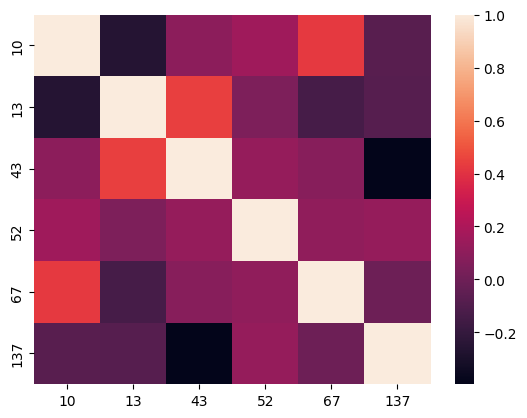

In [272]:
sns.heatmap(data = df_sample.corr())

,center_id,week,num_orders
0,10,0,2570.339071
1,10,1,2397.024757
2,10,2,2243.053087
3,10,3,2298.484799
4,10,4,1644.896285
...,...,...,...
595,137,95,2042.482548
596,137,96,2767.927720
597,137,97,2150.848499
598,137,98,2225.260664


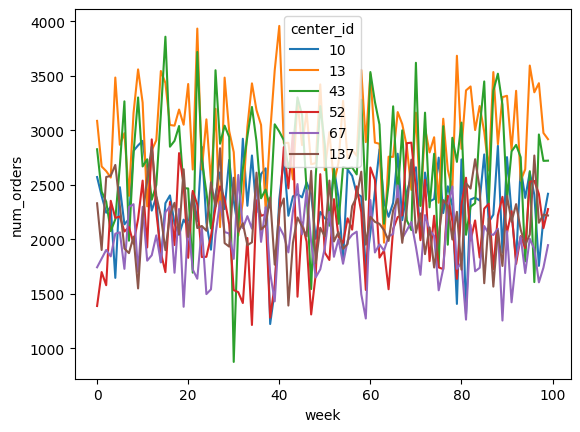

In [273]:
df_temp = df_sample.transpose().stack().to_frame().reset_index()
df_temp.columns = ['center_id', 'week', 'num_orders']
df_temp.center_id = df_temp.center_id.astype(str)
sns.lineplot(data = df_temp, x = 'week', hue = 'center_id', y = 'num_orders')

df_temp

In [274]:
# mat_cov_centers = [[137223.44833, 156691.145063], [156691.145063, 295682.049362]]
# arr_mu_centers = [2966.619286, 2710.857857]
# __size = 140



# def rng_13_43(size = 140):
#     return np.random.multivariate_normal(mean = arr_mu_centers, cov=mat_cov_centers, size = size)


# __rngs = [
#     lambda: scipy.stats.logistic(23273.1, 1791.8 ** 0.5, size = __size),        # 10

#     lambda: scipy.stats.logistic(19481.8, 1765**0.5, size = __size),        # 67

#     lambda: scipy.stats.oglogistic(-10392, 31699, 17.297, size = __size)        #137
# ]

# __cons_rngs_13 = lambda: scipy.stats.logistic(7249.22,527.65 ** 0.5, size = __size)

# __cons_rngs_43 = lambda: scipy.stats.logistic(4822.87,459.52 ** 0.5, size = __size)

In [1]:
118155.549821 ** 0.5

343.7376176984416